In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from math import ceil
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import dask
import cftime

from project.io import IntakeESMLoader, save_mfdataset
from project.plotting import plot_field
from project.util import stack_state, unstack_state, is_dask_array
from project.eof import EOF
from project.spaces import PhysicalSpaceForecastSpaceMapper, Detrend, NanMask

In [3]:
data = xr.open_mfdataset(
    Path("/home/enkf6/dstiller/enspred/training_data/2023-12-03T15-00-42/").glob("**/*.nc")
    )["data"]
data

<xarray.DataArray 'data' (state: 50, time: 22200)>
dask.array<concatenate, shape=(50, 22200), dtype=float64, chunksize=(50, 1200), chunktype=numpy.ndarray>
Coordinates:
  * state    (state) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) object 7001-01-16 12:00:00 ... 8850-12-16 12:00:00

In [4]:
mapper = PhysicalSpaceForecastSpaceMapper.load(Path("/home/enkf6/dstiller/enspred/mapper/mapper-2023-12-03T14-51-55.pkl"))

2023-12-03 14:09:15    INFO PhysicalSpaceForecastSpaceMapper.backward()
2023-12-03 14:09:15    INFO Splitting direct fields for ohc700
2023-12-03 14:09:15    INFO Back-projecting joint EOF for zos, tas, tos, pr, rlut, psl, rsut, zg500, sos
2023-12-03 14:09:15    INFO De-standardizing ohc700 after individual EOF
2023-12-03 14:09:15    INFO Back-projecting EOF for ohc700 [1/10]
2023-12-03 14:09:15    INFO Back-projecting EOF for pr [2/10]
2023-12-03 14:09:15    INFO De-standardizing psl after individual EOF
2023-12-03 14:09:15    INFO Back-projecting EOF for psl [3/10]
2023-12-03 14:09:15    INFO De-standardizing rlut after individual EOF
2023-12-03 14:09:15    INFO Back-projecting EOF for rlut [4/10]
2023-12-03 14:09:15    INFO De-standardizing rsut after individual EOF
2023-12-03 14:09:15    INFO Back-projecting EOF for rsut [5/10]
2023-12-03 14:09:16    INFO De-standardizing sos after individual EOF
2023-12-03 14:09:16    INFO Back-projecting EOF for sos [6/10]
2023-12-03 14:09:16    

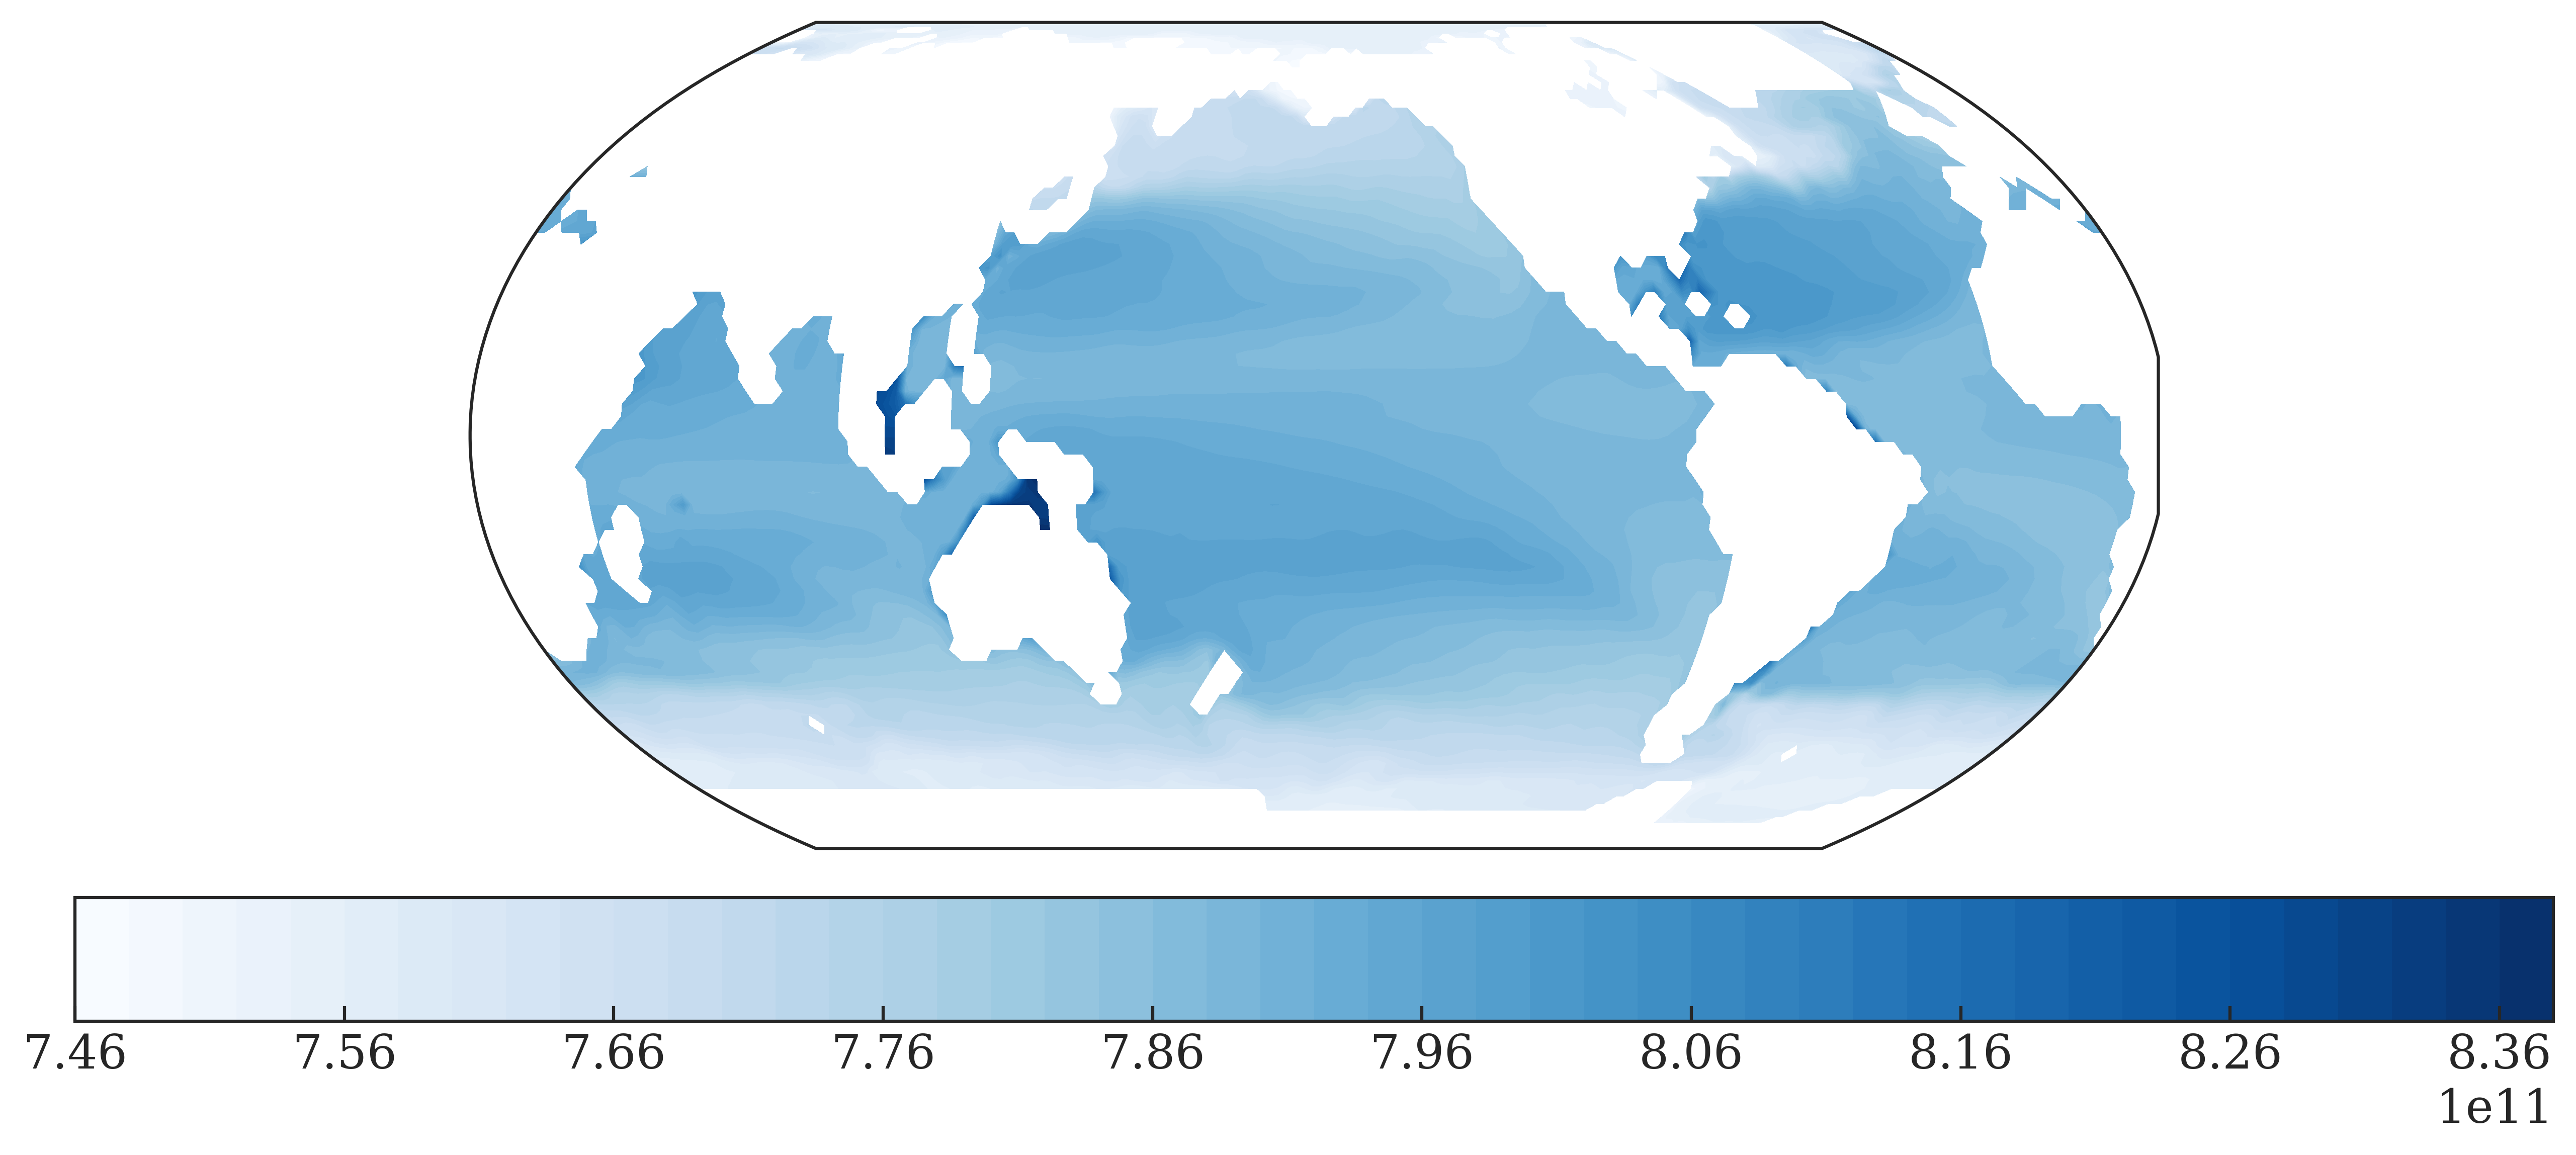

In [8]:
field = "ohc700"
state = mapper.backward(data.isel(time=0).data, data.isel(time=0).time)[field]
# state = xr.DataArray(
#     mapper.nan_masks[field].backward(mapper.eofs_individual[field].get_component(0)[:, np.newaxis]),
#     coords=dict(state=mapper.state_coords[field], time=[0])
# ).unstack("state").squeeze().drop_vars("field").transpose(..., "lat", "lon")

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=198)))
plot_field(ax, state)